# Analyse af COVID-19 Artikler

I denne udfordring vil vi fortsætte med emnet om COVID-pandemien og fokusere på at bearbejde videnskabelige artikler om emnet. Der findes [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) med mere end 7000 (på tidspunktet for skrivningen) artikler om COVID, tilgængelige med metadata og abstracts (og for omkring halvdelen af dem er der også fuld tekst tilgængelig).

Et fuldt eksempel på analyse af dette datasæt ved hjælp af [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) kognitive tjeneste er beskrevet [i dette blogindlæg](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Vi vil diskutere en forenklet version af denne analyse.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Hentning af data

Først skal vi hente metadata for CORD-artikler, som vi skal arbejde med.

**BEMÆRK**: Vi leverer ikke en kopi af datasættet som en del af dette repository. Du skal muligvis først downloade filen [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) fra [dette datasæt på Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Det kan være nødvendigt at registrere sig hos Kaggle. Du kan også downloade datasættet uden registrering [herfra](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), men det vil inkludere alle fuldtekster ud over metadatafilen.

Vi vil forsøge at hente dataene direkte fra en online kilde, men hvis det mislykkes, skal du downloade dataene som beskrevet ovenfor. Det giver også mening at downloade dataene, hvis du planlægger at eksperimentere yderligere med dem, for at spare ventetid.

> **BEMÆRK**, at datasættet er ret stort, omkring 1 GB i størrelse, og følgende linje kode kan tage lang tid at fuldføre! (~5 minutter)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Vi vil nu konvertere kolonnen for udgivelsesdato til `datetime` og plotte histogrammet for at se rækkevidden af udgivelsesdatoer.


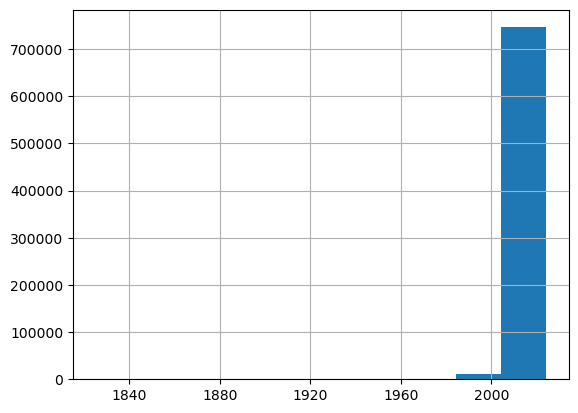

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Struktureret dataudtrækning

Lad os se, hvilken slags information vi nemt kan udtrække fra abstracts. En ting, vi måske er interesserede i, er at undersøge, hvilke behandlingsstrategier der findes, og hvordan de har udviklet sig over tid. Til at begynde med kan vi manuelt sammensætte en liste over mulige medicin, der bruges til at behandle COVID, samt en liste over diagnoser. Derefter gennemgår vi dem og søger efter tilsvarende termer i abstracts fra artikler.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Vi har tilføjet en række kolonner til vores dataframe, der indeholder antallet af gange, en given medicin/diagnose optræder i abstraktet.

> **Bemærk** at vi tilføjer et mellemrum i starten af ordet, når vi søger efter en delstreng. Hvis vi ikke gør det, kan vi få forkerte resultater, fordi *chloroquine* også ville blive fundet inde i delstrengen *hydroxychloroquine*. Derudover tvinger vi konvertering af abstrakt-kolonnen til `str` for at undgå en fejl - prøv at fjerne `str` og se, hvad der sker.

For at gøre arbejdet med data lettere kan vi udtrække en under-ramme med kun medicinoptællinger og beregne det samlede antal forekomster. Dette giver os den mest populære medicin:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

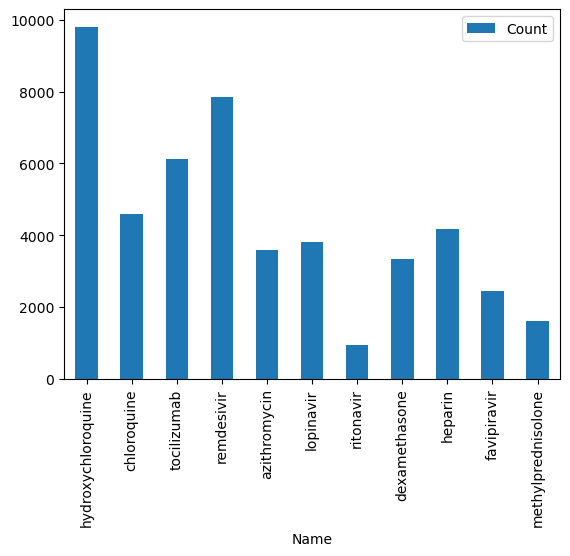

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Søger efter tendenser i behandlingsstrategi

I eksemplet ovenfor har vi `sum`met alle værdier, men vi kan også gøre det samme på månedsbasis:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

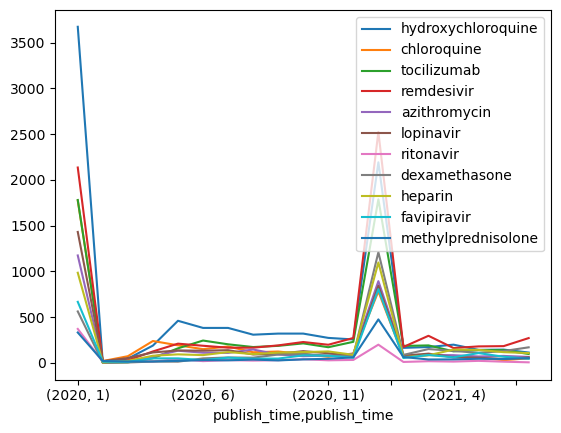

In [152]:
dfmt.plot()
plt.show()

En interessant observation er, at vi har store udsving på to tidspunkter: januar 2020 og januar 2021. Dette skyldes, at nogle artikler ikke har en klart angivet udgivelsesdato, og de er angivet som januar i det respektive år.

For at give mere mening til dataene, lad os visualisere kun nogle få mediciner. Vi vil også "slette" data for januar og erstatte dem med en gennemsnitsværdi for at skabe et pænere diagram:


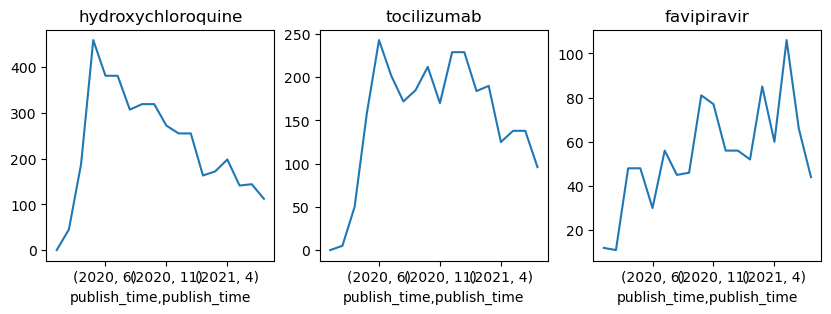

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

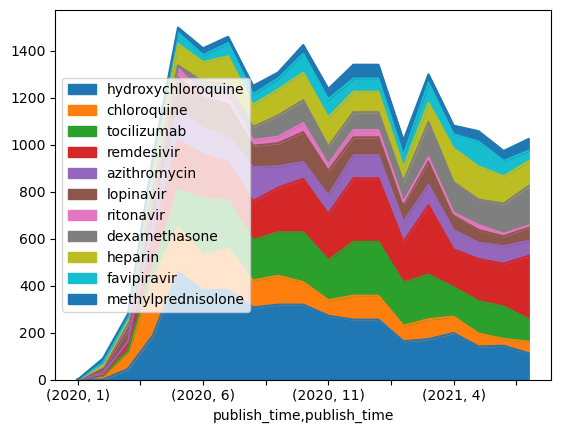

In [154]:
dfmt.plot.area()
plt.show()

Endnu videre kan vi beregne relativ popularitet i procent:


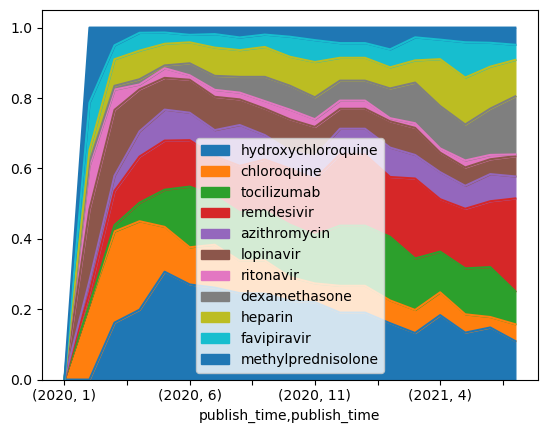

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Beregning af korrespondance mellem medicin og diagnoser

En af de mest interessante sammenhænge, vi kan undersøge, er hvordan forskellige diagnoser behandles med forskellige mediciner. For at visualisere dette skal vi beregne et **samsynsfrekvenskort**, som viser, hvor mange gange to termer nævnes i samme artikel.

Et sådant kort er i bund og grund en 2D-matrix, som bedst repræsenteres ved en **numpy array**. Vi vil beregne dette kort ved at gennemgå alle abstracts og markere de enheder, der forekommer der:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

En af måderne at visualisere denne matrix på er at tegne et **heatmap**:


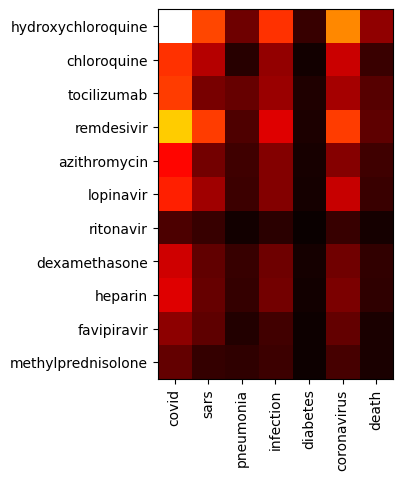

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Men endnu bedre visualisering kan opnås ved hjælp af det såkaldte **Sankey**-diagram! `matplotlib` har ikke indbygget understøttelse af denne diagramtype, så vi bliver nødt til at bruge [Plotly](https://plotly.com/python/) som beskrevet [i denne tutorial](https://plotly.com/python/sankey-diagram/).

For at lave et Sankey-diagram med Plotly skal vi opbygge følgende lister:
* Listen `all_nodes` med alle noder i grafen, som vil inkludere både medicin og diagnoser
* Lister over kilde- og målindekser - disse lister vil vise, hvilke noder der går til venstre, og hvilke der går til højre i diagrammet
* Liste over alle forbindelser, hvor hver forbindelse består af:
   - Kildeindeks i `all_nodes`-arrayet
   - Målindeks
   - Værdi, der angiver styrken af forbindelsen. Dette er præcis værdien fra vores co-occurence matrix.
   - Eventuelt farve på forbindelsen. Vi vil lave en mulighed for at fremhæve nogle af termerne for tydelighed.

Generisk kode til at tegne Sankey-diagrammet er struktureret som en separat `sankey`-funktion, der tager to lister (kilde- og mål-kategorier) og co-occurence matrix. Den giver os også mulighed for at angive en tærskel og udelade alle forbindelser, der er svagere end denne tærskel - dette gør diagrammet lidt mindre komplekst.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Konklusion

Du har set, at vi kan bruge ret simple metoder til at udtrække information fra ustrukturerede datakilder, såsom tekst. I dette eksempel har vi taget den eksisterende liste over medicin, men det ville være langt mere kraftfuldt at anvende teknikker inden for naturlig sprogbehandling (NLP) til at udføre enhedsudtrækning fra tekst. I [denne blogpost](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) beskriver vi, hvordan man kan bruge cloud-tjenester til enhedsudtrækning. En anden mulighed kunne være at anvende Python NLP-biblioteker såsom [NLTK](https://www.nltk.org/) - en tilgang til at udtrække information fra tekst ved hjælp af NLTK er beskrevet [her](https://www.nltk.org/book/ch07.html).


## Udfordring

Fortsæt med at undersøge COVID-papirdataene langs følgende linjer:

1. Byg en co-forekomstmatrix for forskellige medicin, og se hvilke medicin der ofte optræder sammen (dvs. nævnt i samme abstrakt). Du kan tilpasse koden til at bygge en co-forekomstmatrix for medicin og diagnoser.
1. Visualisér denne matrix ved hjælp af et heatmap.
1. Som et ekstra mål kan du forsøge at visualisere co-forekomsten af medicin ved hjælp af [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [Dette bibliotek](https://pypi.org/project/chord/) kan hjælpe dig med at tegne et chord diagram.
1. Som endnu et ekstra mål kan du prøve at udtrække doseringer af forskellige medicin (såsom **400mg** i *tag 400mg chloroquine dagligt*) ved hjælp af regulære udtryk og opbygge en dataframe, der viser forskellige doseringer for forskellige medicin. **Bemærk**: overvej numeriske værdier, der er i tæt tekstlig nærhed af medicinnavnet.



---

**Ansvarsfraskrivelse**:  
Dette dokument er blevet oversat ved hjælp af AI-oversættelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selvom vi bestræber os på nøjagtighed, skal du være opmærksom på, at automatiserede oversættelser kan indeholde fejl eller unøjagtigheder. Det originale dokument på dets oprindelige sprog bør betragtes som den autoritative kilde. For kritisk information anbefales professionel menneskelig oversættelse. Vi er ikke ansvarlige for eventuelle misforståelser eller fejltolkninger, der opstår som følge af brugen af denne oversættelse.
